In [73]:
#Code for 1 and 2 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import itertools
from sklearn.preprocessing import MinMaxScaler

from scipy import stats

from sklearn.metrics import mean_absolute_error, r2_score

import warnings
warnings.filterwarnings('ignore')

# Importing and Cleaning Data

In [74]:
#Read the primary and secondary sales files
secondary_sales = pd.read_csv("WC_DS_Ex1_Sec_Sales.csv",parse_dates=[3],index_col=[3]).sort_index()
primary_sales = pd.read_csv("WC_DS_Ex1_Pri_Sales.csv",parse_dates=[3],index_col=[3]).sort_index()
invoice_record = pd.read_csv("WC_DS_EX1_Inv.csv",parse_dates=[3],index_col=[3]).sort_index()

1. Aggregate the Sales_Qty for each Store-SKU at a month level; detect any Outliers in the
Sales_Qty for each Store-SKU combination and apply an outlier treatment on the same.
Specify the outlier treatment technique.
2. Estimate the level of promotions (Discount%) for each Category-Store level at a month
level - remove any outliers / inconsistencies from this, and specify the technique used;
the level of promotions is defined as Discount% = (1 - sum of SP / sum of MRP)

In [75]:
secondary_sales.head()

,Store_Code,SKU_Code,Category,Sales_Qty,MRP,SP
Date,,,,,,
2016-01-01,Store3,603693,Cat1,1,1095.0,1095.0
2016-01-01,Store3,614427,Cat2,1,645.0,645.0
2016-01-01,Store1,610221,Cat1,1,1095.0,808.7
2016-01-01,Store2,600252,Cat1,1,1095.0,808.7
2016-01-01,Store3,600960,Cat2,1,795.0,795.0


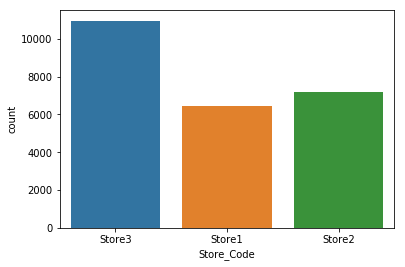

In [76]:
c1 = sns.countplot(secondary_sales['Store_Code'])

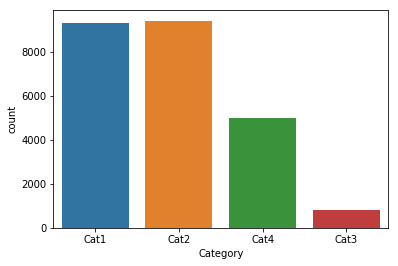

In [77]:
c1 = sns.countplot(secondary_sales['Category'])

# ANALYSIS ON STORE BASIS ON SECONDARY SALE

In [78]:
operation_store = 'Store3'

In [79]:
def resample_store_weekly(df,store_code):
    '''
    Parameter: df Dataframe for secondary sales data
            store_code : subset data for that store
            
    This function subset the data from secondary sales for a particular store and then resample it on weekly basis.
    MRP and SP are resample over week with mean and sales_Qty is sum over the week.
    MRP and SP are price for individual SKU_Code.
    
    We also calculate promotions. And replace NAN with 0.
    NAN are created for october 2017 , for which we do not have data in secondary sales.
    '''
    Store =  df['Store_Code'] == store_code
    Store_secondary_sales = df[Store]
    Store_secondary_sales_week = pd.DataFrame()
    Store_secondary_sales_week_sum = Store_secondary_sales[['Sales_Qty']].resample('W').sum()    
    Store_secondary_sales_week_mean = Store_secondary_sales[['MRP','SP']].resample('W').mean()
    Store_secondary_sales_week['MRP'] = Store_secondary_sales_week_mean['MRP']
    Store_secondary_sales_week['SP'] = Store_secondary_sales_week_mean['SP']
    Store_secondary_sales_week['Promotions'] = 1-Store_secondary_sales_week['SP']/Store_secondary_sales_week['MRP']
    Store_secondary_sales_week['Store_Code'] = store_code
    Store_secondary_sales_week['Sales_Qty'] = Store_secondary_sales_week_sum['Sales_Qty']
    #Handling NAN values
    Store_secondary_sales_week.fillna(0,inplace=True)
    Store_secondary_sales_week
    print(Store_secondary_sales_week.head())
    
    return Store_secondary_sales_week

In [80]:
Store1_secondary_sales_week = resample_store_weekly(secondary_sales,operation_store)

                    MRP          SP  Promotions Store_Code  Sales_Qty
Date                                                                 
2016-01-03   917.285714  775.398095    0.154682     Store3         97
2016-01-10   872.581699  759.466667    0.129633     Store3        139
2016-01-17  1045.824742  800.078351    0.234979     Store3        182
2016-01-24  1036.212121  810.615152    0.217713     Store3        124
2016-01-31  1012.526882  790.181720    0.219594     Store3        174


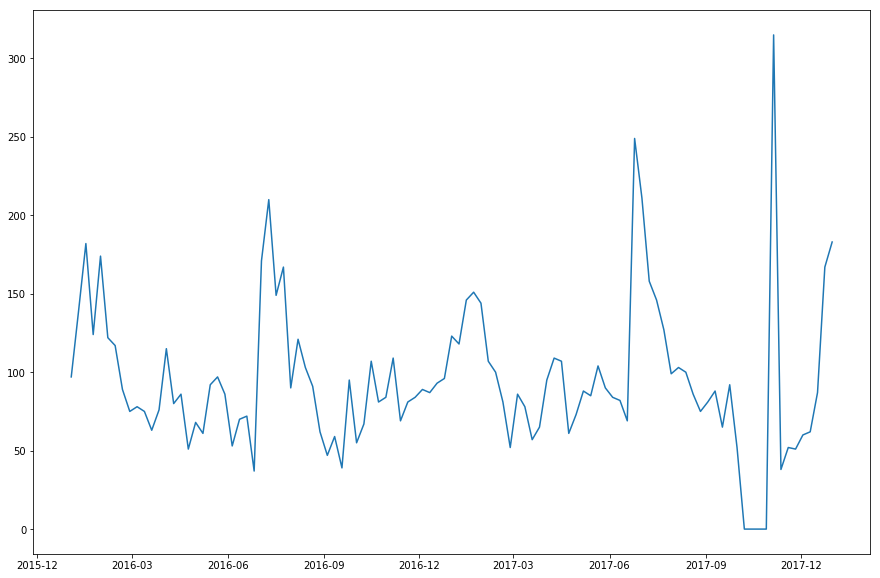

In [81]:
plt.figure(figsize=(15,10))
plt.plot(Store1_secondary_sales_week.index,'Sales_Qty',data=Store1_secondary_sales_week)

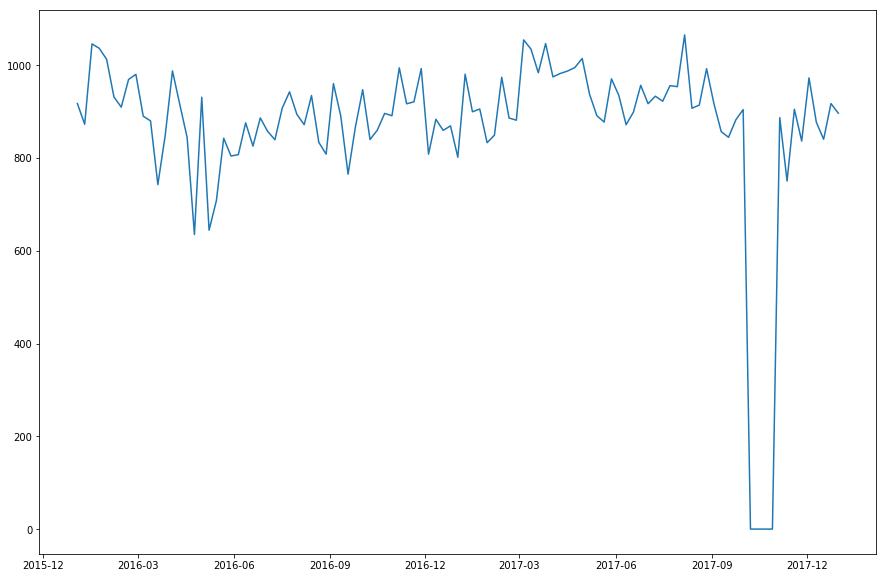

In [82]:
plt.figure(figsize=(15,10))
plt.plot(Store1_secondary_sales_week.index,'MRP',data=Store1_secondary_sales_week)

If you look at above two plot of MRP and Sales_Qty . We can simply say that replacing NAN with 0 is not a good idea . It also does not look the part for the graph . Now we have option for imputation of these 0 values with mean,mode,median.

# Handling missing values

NOTE :Here i can not use the imputation , since it get stock from the primary source and there is chance the store have no stock/no moment of stock from primary to secondary . But looking at the pattern of MRP,SP or promotions ,look like data is missing for that October.

In [83]:
Store1_secondary_sales_week=Store1_secondary_sales_week.replace({'MRP': {0: Store1_secondary_sales_week['MRP'].mean()}}) 
Store1_secondary_sales_week=Store1_secondary_sales_week.replace({'SP': {0: Store1_secondary_sales_week['SP'].mean()}})
Store1_secondary_sales_week=Store1_secondary_sales_week.replace({'Sales_Qty': {0: Store1_secondary_sales_week['Sales_Qty'].mean()}}) 
Store1_secondary_sales_week['Promotions'] = 1-Store1_secondary_sales_week['SP']/Store1_secondary_sales_week['MRP']

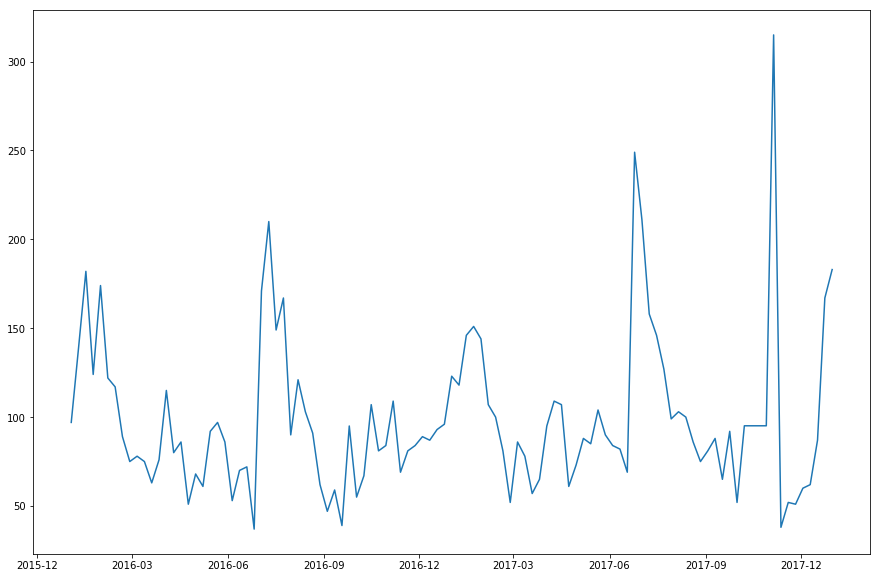

In [84]:
plt.figure(figsize=(15,10))
plt.plot(Store1_secondary_sales_week.index,'Sales_Qty',data=Store1_secondary_sales_week)

I tested all 3 mode for imputation data : mean ,median and mode. 
There was no so much significant difference .
Default i start with mean for imputation .

# Techniques for outlier detection

In [85]:
Store1_secondary_sales_week.head()

,MRP,SP,Promotions,Store_Code,Sales_Qty
Date,,,,,
2016-01-03,917.285714,775.398095,0.154682,Store3,97.0
2016-01-10,872.581699,759.466667,0.129633,Store3,139.0
2016-01-17,1045.824742,800.078351,0.234979,Store3,182.0
2016-01-24,1036.212121,810.615152,0.217713,Store3,124.0
2016-01-31,1012.526882,790.181720,0.219594,Store3,174.0


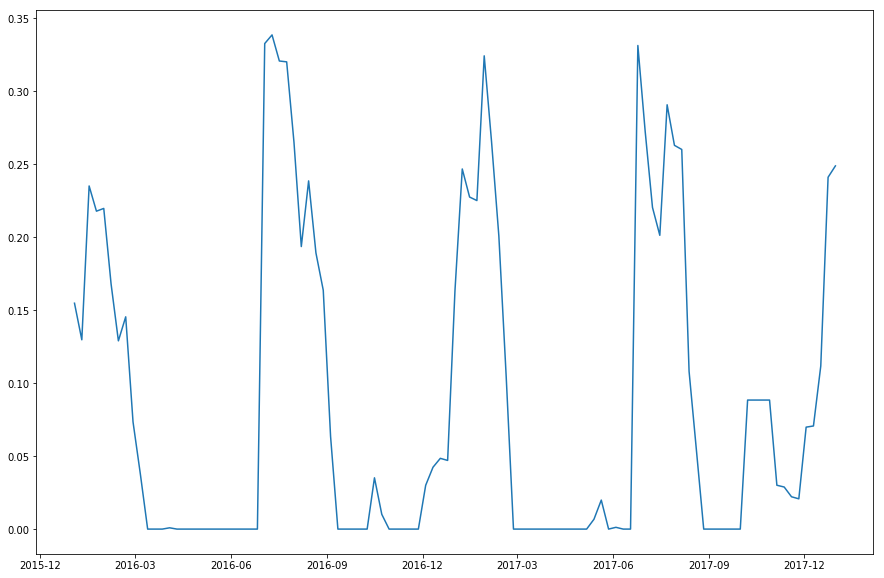

In [86]:
plt.figure(figsize=(15,10))
plt.plot(Store1_secondary_sales_week.index,'Promotions',data=Store1_secondary_sales_week)

Now we can In October 2016 there is also some hike in promotions , similar pattern is also introduce int 2017 October . After doing inputation of missing values

Looking at promotions VS Date and sales_Qty VS Date . It is clear that they are highly co-related , and promotions has high effect on sales_Qty. 
Even we can see the linear trend between Sales_Qty and promotions.

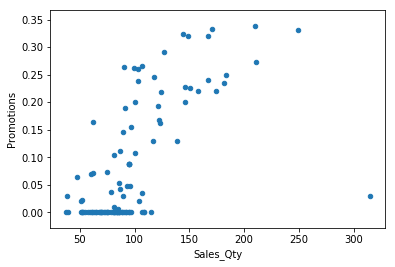

In [87]:
Store1_secondary_sales_week.plot.scatter('Sales_Qty','Promotions')

In [88]:
Store1_secondary_sales_week.head()

,MRP,SP,Promotions,Store_Code,Sales_Qty
Date,,,,,
2016-01-03,917.285714,775.398095,0.154682,Store3,97.0
2016-01-10,872.581699,759.466667,0.129633,Store3,139.0
2016-01-17,1045.824742,800.078351,0.234979,Store3,182.0
2016-01-24,1036.212121,810.615152,0.217713,Store3,124.0
2016-01-31,1012.526882,790.181720,0.219594,Store3,174.0


In [89]:
def remove_outlier(df,column,outlier_options='mean',threshold = 3):
    '''
    Function paramter : df Dataframe for secondary sales
                column : on which outlier detection analysis is performed
                outlier_option : This is the outlier treatment options
                    1.mean (default)
                    2.median
                    3.mode
                threshold : outlier detection limit (default 3)
                    
                    Z-score gives the variation of each data point and how much far it lies from the mean
                    Threshold is selected as 3 by default
    '''

    Store_secondary_sales_week_nooutlier = pd.DataFrame()
    df['Z-score'] = np.abs(stats.zscore(df[column]))
    Z =  df['Z-score'] < threshold
    if outlier_options is None:
        df.loc[df['Z-score'] > threshold, column] = df[column].mean()
    if outlier_options == 'mean':
        df.loc[df['Z-score'] > threshold, column] = df[column].mean()
    if outlier_options == 'median':
        df.loc[df['Z-score'] > threshold, column] = df[column].median()
    if outlier_options is 'mode':
        df.loc[df['Z-score'] > threshold, column] = df[column].mode()[0]
    print(Z.value_counts())
    print("False count shows the number of outliers")
    print("Imputing Outlier with ",outlier_options)
    df.drop(columns=['Z-score'],axis=1,inplace=True)
    #print(Store_secondary_sales_week_nooutlier)
    return df

In [90]:
Store1_secondary_sales_week_nooutlier = remove_outlier(Store1_secondary_sales_week,'Sales_Qty')

True     103
False      2
Name: Z-score, dtype: int64
False count shows the number of outliers
Imputing Outlier with  mean


In [91]:
Store1_secondary_sales_week_nooutlier = remove_outlier(Store1_secondary_sales_week_nooutlier,'Promotions')

True    105
Name: Z-score, dtype: int64
False count shows the number of outliers
Imputing Outlier with  mean


In [92]:
Store1_secondary_sales_week_nooutlier.reset_index(inplace=True)
Store1_secondary_sales_week_nooutlier.head()

,Date,MRP,SP,Promotions,Store_Code,Sales_Qty
0,2016-01-03,917.285714,775.398095,0.154682,Store3,97.0
1,2016-01-10,872.581699,759.466667,0.129633,Store3,139.0
2,2016-01-17,1045.824742,800.078351,0.234979,Store3,182.0
3,2016-01-24,1036.212121,810.615152,0.217713,Store3,124.0
4,2016-01-31,1012.526882,790.181720,0.219594,Store3,174.0


3. Estimate the inventory levels at a weekly level for each Store-SKU by interpolating
missing values from data on secondary and primary sales; the following equation holds
true in general: ( you can do this for a shorter period of Jan 2017 to Mar 2017 )


    Closing inventory on day [t] = Closing inventory on day [t-1] - Secondary (sales - returns) on day [t] + Primary (sales - returns) on day [t]

    NOTE:
    a. Secondary sales is the file named “WC_DS_Ex1_Sec_Sales.csv” - and it refers
    to sales from stores to customers (and returns by customers)
    b. Primary sales is the file name “WC_DS_Ex1_Pri_Sales.csv” - and it refers to
    stock movements from retailer WH to stores (and returns back to WH)
    c. Returns in both datasets are indicated by negative values in ‘Sales_Qty’ and ‘Qty’
    fields respectively
4. The inventory estimations in Question 3 will have data inconsistencies - take any
assumption to resolve them and explain that assumption

# ANALYSIS FOR CLOSING INVENTORY

In [93]:
def closing_inventory_weekly(df,secondary_sales,store_code):
    '''
    function parameter : df primary_sales data
                        secondary_sales
                        store_code : subset primary sales on store basis
    
    Primary sales resample at weekly basis . As lot of missing weekly column are there those are replaced with 0.
    Primary sales data start from December 2015 whereas Secondary sales data starts from January 2016.
    Primary and secondary sales frame on the basis of Date as reference.
    closing inventory at weekly level is calculated.
    
    Problems: After merge again , we need to convert the column into int.
    '''
    Store = df['Store_Code'] == store_code
    Store_primary_sales = df[Store]
    Store_primary_sales.drop(columns=['SKU_Code','Category'],axis=1,inplace=True)
    Store_primary_sales_week = Store_primary_sales.resample('W').sum()
    Store_primary_sales_week.reset_index(inplace=True)
    #Combine primary and secondary sales data
    Store_primary_secondary = pd.merge(Store_primary_sales_week,secondary_sales,how='left',on=['Date'])
    Store_primary_secondary = Store_primary_secondary.replace(np.nan,'0',regex=True)
    Store_primary_secondary['Store_Code'] = store_code
    
    Store_primary_secondary[['Sales_Qty','MRP','SP','Promotions']] = Store_primary_secondary[['Sales_Qty','MRP','SP','Promotions']].astype(int)
    Store_primary_secondary['Promotions'] = 1 - Store_primary_secondary['SP']/Store_primary_secondary['MRP']
    Store_primary_secondary['Promotions'].fillna(0,inplace=True)
    
    close_inventory = []
    for i in range(len(Store_primary_secondary)):
        if i == 0:
            close_inventory.append(Store_primary_secondary.loc[:i,'Qty'][0])
        else:
            last = int(close_inventory[i-1])
            a = int(list(Store_primary_secondary.loc[i:i,'Sales_Qty'])[0])
            b = int(list(Store_primary_secondary.loc[i:i,'Qty'])[0])        
            result = last - a + b
            close_inventory.append(result)
    
    Store_primary_secondary['closing-inventory'] = close_inventory
    print(Store_primary_secondary.head())
    return Store_primary_secondary

In [94]:
Store1_PSW = closing_inventory_weekly(primary_sales,Store1_secondary_sales_week_nooutlier,operation_store)

        Date  Qty  MRP   SP  Promotions Store_Code  Sales_Qty  \
0 2015-12-13  149    0    0    0.000000     Store3          0   
1 2015-12-20  434    0    0    0.000000     Store3          0   
2 2015-12-27    0    0    0    0.000000     Store3          0   
3 2016-01-03  144  917  775    0.154853     Store3         97   
4 2016-01-10    0  872  759    0.129587     Store3        139   

   closing-inventory  
0                149  
1                583  
2                583  
3                630  
4                491  


# PLOT OF QTY VS DATE

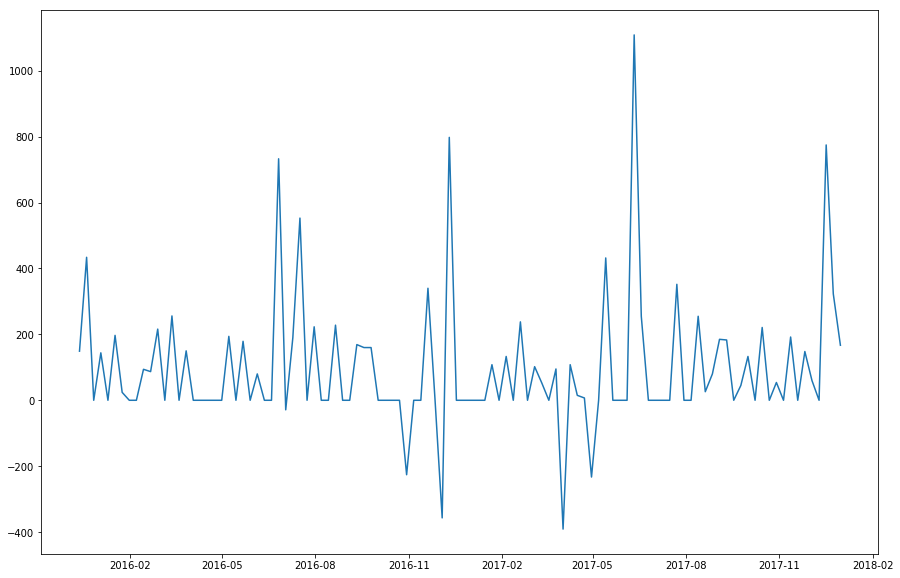

In [95]:
plt.figure(figsize=(15,10))
plt.plot('Date','Qty',data=Store1_PSW)

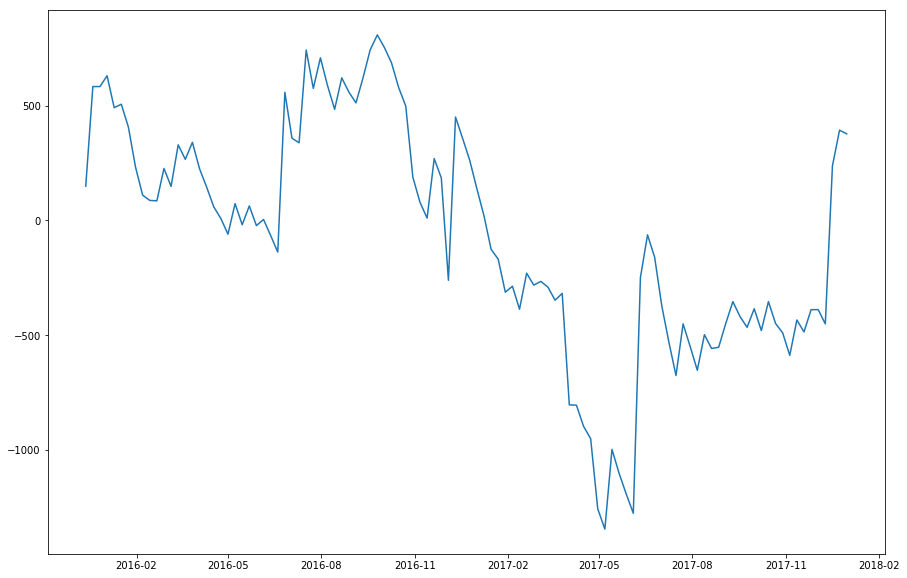

In [96]:
plt.figure(figsize=(15,10))
plt.plot('Date','closing-inventory',data=Store1_PSW)

This graph looks shocking to me . I am not able to understand the reason for this much negativity .

# 5.1 Average out of Stock percentage - secondary sales

In [97]:
def averarge_OOS_store(df,psw,store_code):
    '''
    function paramter: df secondary sales data
        store_code : 
     Filter out the data on the basis of store_code
    Calculates average out of stock percentage 
    psw data contain closing inventory
    '''
    
    Average_OOS = []
    Average_OOS_df = pd.DataFrame()
    
    Store = df['Store_Code'] == store_code
    Store_second_sales = df[Store]
    Store_second_sales = Store_second_sales[['Store_Code','SKU_Code']]
    Store_second_sales.reset_index(inplace=True)

    column_1 = Store_second_sales['Date']
    temp = pd.DataFrame({"year": column_1.dt.year,
                  "month": column_1.dt.month,
                  "day": column_1.dt.day
                 })

    Store_second_sales.reset_index(drop=True, inplace=True)
    temp.reset_index(drop=True, inplace=True)
    Store_second_sales = pd.concat([Store_second_sales,temp],axis=1)
    
    Date_list = Store_second_sales['Date'].unique()
    for index in Date_list:
        index = pd.to_datetime(index)
        #print(index)
        year = int(index.strftime("%Y"))
        month = int(index.strftime("%m"))
        day = int(index.strftime("%d"))
        #Select the specfic year
        year_select = Store_second_sales['year'] == year
        Store_second_sales_year = Store_second_sales[year_select]
        #Select specfic month
        month_select = Store_second_sales_year['month'] == month
        Store_second_sales_year_month = Store_second_sales_year[month_select]
        #SKU Code month level
        SKU_code_month_count = len(Store_second_sales_year_month['SKU_Code'].unique())
        #Select specfic day
        day_select = Store_second_sales_year_month['day'] == day
        Store_second_sales_year_month_day = Store_second_sales_year_month[day_select]
        #SKU Code day count
        SKU_code_day_count = len(Store_second_sales_year_month_day['SKU_Code'].unique())
        Average_OOS.append(1-SKU_code_day_count/SKU_code_month_count)
    
    Average_OOS_df['Date'] = Date_list
    Average_OOS_df['Average_OOS'] = Average_OOS
    #Dealing with missing data 
    Average_OOS_df=pd.merge(psw,Average_OOS_df,how='left',on='Date')
    #This is due to fact we do have data for December 2015 and even sales_Qty are zero , probabily stock moment time
    Average_OOS_df=Average_OOS_df.replace({'Average_OOS': {np.nan: Average_OOS_df['Average_OOS'].mean()}}) 
 
    print(Average_OOS_df.head())
    return Average_OOS_df

In [98]:
Store1 = averarge_OOS_store(secondary_sales,Store1_PSW,operation_store)

        Date  Qty  MRP   SP  Promotions Store_Code  Sales_Qty  \
0 2015-12-13  149    0    0    0.000000     Store3          0   
1 2015-12-20  434    0    0    0.000000     Store3          0   
2 2015-12-27    0    0    0    0.000000     Store3          0   
3 2016-01-03  144  917  775    0.154853     Store3         97   
4 2016-01-10    0  872  759    0.129587     Store3        139   

   closing-inventory  Average_OOS  
0                149     0.930122  
1                583     0.930122  
2                583     0.930122  
3                630     0.903448  
4                491     0.885057  


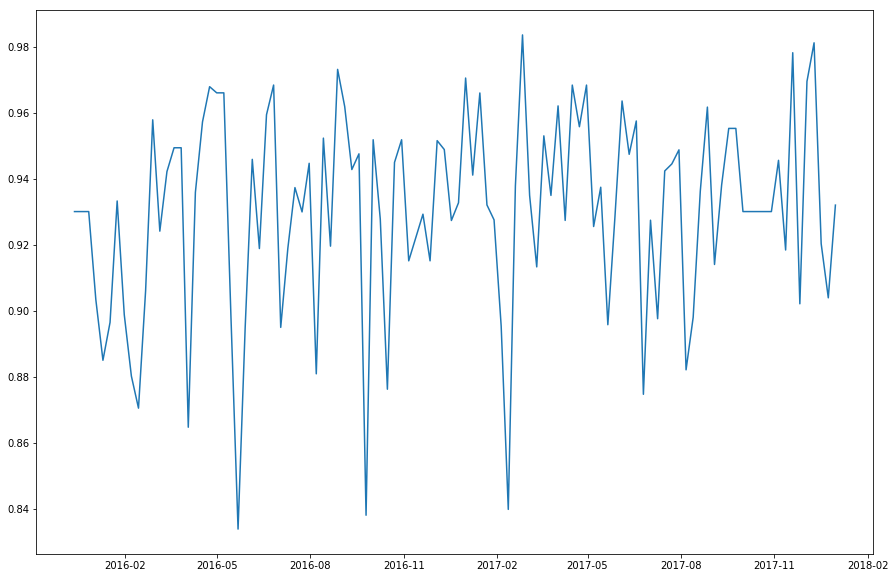

In [99]:
plt.figure(figsize=(15,10))
plt.plot('Date','Average_OOS',data=Store1)

# 6.Model preperation

In [100]:
#Remove the reading for 2015 reading as most of them are by imputation
Store1 = Store1.iloc[3:,]

In [101]:
train = Store1[0:90]
test = Store1[90:]

In [102]:
train = train.set_index('Date')
test = test.set_index('Date')

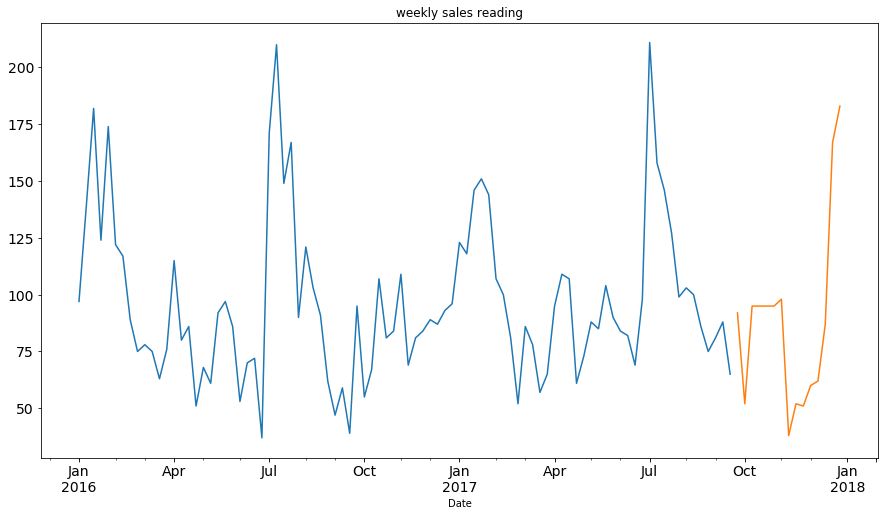

In [103]:
train.Sales_Qty.plot(figsize=(15,8), title= 'weekly sales reading', fontsize=14)
test.Sales_Qty.plot(figsize=(15,8), title= 'weekly sales reading', fontsize=14)
plt.show()

# 6.1Holt winter Exponential smoothing method method

In [104]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

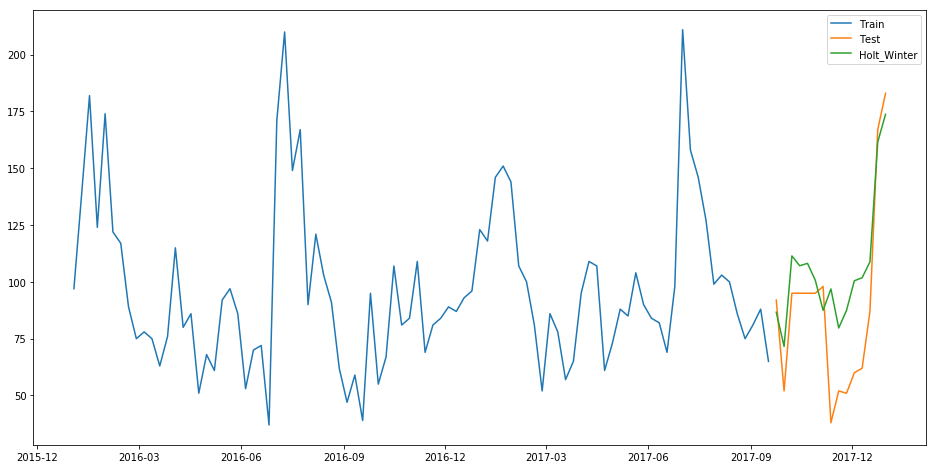

In [105]:
y_hat_avg = test.copy()
y_hat_avg['Promotions'] = 1- y_hat_avg['SP']/y_hat_avg['MRP']
fit1 = ExponentialSmoothing(np.asarray(train['Sales_Qty']) ,seasonal_periods=7 ,trend='add', seasonal='add').fit(smoothing_level=0.5)
y_hat_avg['Holt_Winter'] = fit1.forecast(len(test))
plt.figure(figsize=(16,8))
plt.plot( train['Sales_Qty'], label='Train')
plt.plot(test['Sales_Qty'], label='Test')
y_hat_avg['Holt_Winter'] = y_hat_avg['Holt_Winter'] + y_hat_avg['Promotions']*350
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter')
plt.legend(loc='best')
plt.show()

In [106]:
print(mean_absolute_error(y_hat_avg['Holt_Winter'], y_hat_avg['Sales_Qty']))

21.51506087027867


# 6.2.ML Approach

In [107]:
column_1 = Store1['Date']

temp = pd.DataFrame({"year": column_1.dt.year,
              "month": column_1.dt.month,
              "day": column_1.dt.day,
              "dayofyear": column_1.dt.dayofyear,
              "week": column_1.dt.week
             })

Store1.reset_index(drop=True, inplace=True)
temp.reset_index(drop=True, inplace=True)
Store1 = pd.concat([Store1,temp],axis=1)

The first step for the ML approach is to create the feature that we will predict. In our example we don't predict the number of visits but the difference between two days. The tips to create few features is to take the difference between two days and to do a lag. Here we will take a lag of "diff" seven times. If you have a weekly pattern it is an interesting choice. Here we have few data (2 months so 30 values) and it is a contraint. I done some test and the number 7 is a good choice (weekly pattern?).

In [108]:
Store1.head()

,Date,Qty,MRP,SP,Promotions,Store_Code,Sales_Qty,closing-inventory,Average_OOS,year,month,day,dayofyear,week
0,2016-01-03,144,917,775,0.154853,Store3,97,630,0.903448,2016,1,3,3,53
1,2016-01-10,0,872,759,0.129587,Store3,139,491,0.885057,2016,1,10,10,1
2,2016-01-17,197,1045,800,0.234450,Store3,182,506,0.896552,2016,1,17,17,2
3,2016-01-24,24,1036,810,0.218147,Store3,124,406,0.933333,2016,1,24,24,3
4,2016-01-31,0,1012,790,0.219368,Store3,174,232,0.898851,2016,1,31,31,4


In [109]:
from datetime import timedelta

# Forceasting with decompasable model
from pylab import rcParams
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

# For marchine Learning Approach
from statsmodels.tsa.tsatools import lagmat
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

In [110]:
def lag_func(data,lag,col):
    lag = lag
    X = lagmat(data["diff"], lag)
    lagged = data.copy()
    for c in range(1,lag+1):
        lagged[col+"%d" % c] = X[:, c-1]
    return lagged

def diff_creation(data,index):
    data['diff'] = 0
    data.ix[1:, "diff"] = (data.iloc[1:,index ].as_matrix() - data.iloc[:len(data)-1, index].as_matrix())
    return data

lag=7
df_count = diff_creation(Store1,6)
lagged = lag_func(df_count,lag,'sales')

In [111]:
def lag_func(data,lag,col):
    lag = lag
    X = lagmat(data["diff_s"], lag)
    lagged = data.copy()
    for c in range(1,lag+1):
        lagged[col+"%d" % c] = X[:, c-1]
    return lagged

def diff_creation(data,index):
    data['diff_s'] = 0
    data.ix[1:, "diff_s"] = (data.iloc[1:,index ].as_matrix() - data.iloc[:len(data)-1, index].as_matrix())
    return data

lag=10
lagged = diff_creation(lagged,4)
lagged = lag_func(lagged,lag,'promo')

In [112]:
pred = list(lagged)
pred.remove('Sales_Qty')
pred.remove('Date')
pred.remove('Store_Code')

In [113]:
target = lagged['Sales_Qty']
lagged.drop(columns=['Date','Store_Code','Sales_Qty'],axis=1,inplace=True)

In [114]:
from sklearn import preprocessing
lagged = preprocessing.scale(lagged)

In [115]:
from sklearn.model_selection import train_test_split
X_train , X_test , y_train,y_test = train_test_split(lagged,target,test_size=0.2,random_state=29)

-----------------------------------------------
mae with 80% of the data to train: 17.08549075461661
-----------------------------------------------


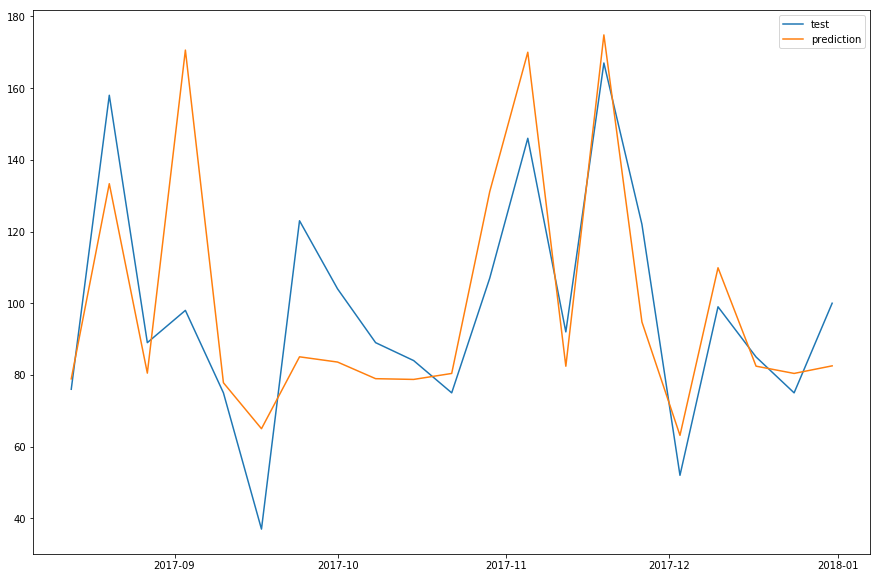

In [116]:
# Linear Model
from sklearn.ensemble import ExtraTreesRegressor,GradientBoostingRegressor, BaggingRegressor, AdaBoostRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import RandomizedSearchCV

def modelisation(x_tr, y_tr, x_ts, y_ts, model):
    # Modelisation with all product
    model.fit(x_tr, y_tr)

    prediction = model.predict(x_ts)
    r2 = r2_score(y_ts.as_matrix(), model.predict(x_ts))
    mae = mean_absolute_error(y_ts.as_matrix(), model.predict(x_ts))
    print ("-----------------------------------------------")
    print ("mae with 80% of the data to train:", mae)
    print ("-----------------------------------------------")

    return model,prediction

#model0 =  AdaBoostRegressor(n_estimators = 5000, random_state = 42, learning_rate=0.01)
#model =  AdaBoostRegressor(n_estimators = 5000, random_state = 42, learning_rate=0.001)

param_dist = {
 'n_estimators': [50, 100,500,1000,1500],
 'learning_rate' : [0.0001,0.001,0.01],
 'loss' : ['linear', 'square', 'exponential'],
    
 }

#model = RandomizedSearchCV(AdaBoostRegressor(),param_distributions = param_dist,cv=3,n_iter = 40,n_jobs=-1)
#model.fit(X_train,y_train)

best_model = AdaBoostRegressor(n_estimators=100, loss='square', learning_rate=0.01)
#best_model = ExtraTreesRegressor()
#best_model = GradientBoostingRegressor()
#best_model = BaggingRegressor()

clr,prediction  = modelisation(X_train, y_train, X_test, y_test,best_model)
x = Store1.iloc[len(X_train):,]
plt.figure(figsize=(15,10))
plt.plot(x['Date'],np.array(y_test),label='test')
plt.plot(x['Date'],np.array(prediction),label='prediction')
plt.legend()


In [117]:
model.best_params_

{'n_estimators': 1000, 'loss': 'huber', 'learning_rate': 0.01}

In [118]:
param_dist = {
 'n_estimators': [50, 100,500,1000,1500],
 'learning_rate' : [0.0001,0.001,0.01],
 'loss' : ['ls', 'lad', 'huber', 'quantile'],
}

model = RandomizedSearchCV(GradientBoostingRegressor(),param_distributions = param_dist,cv=5,n_iter = 40,n_jobs=-1)
model.fit(X_train,y_train)
model.best_params_


{'n_estimators': 1500, 'loss': 'huber', 'learning_rate': 0.01}

# Gradient Based Regressor

-----------------------------------------------
mae with 80% of the data to train: 13.373631141932325
-----------------------------------------------


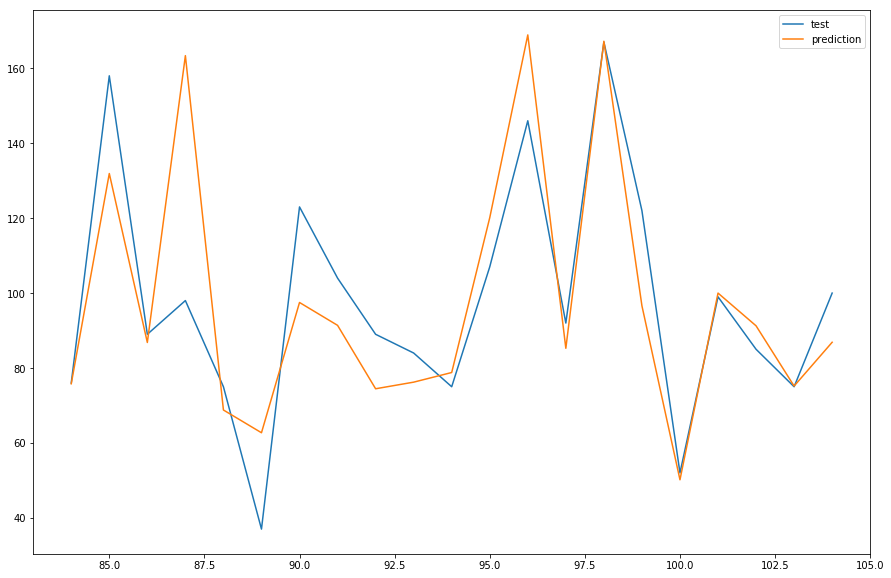

In [119]:
best_model = GradientBoostingRegressor(n_estimators= 1000,loss= 'huber', learning_rate= 0.01)
#best_model = BaggingRegressor()
clr,prediction  = modelisation(X_train, y_train, X_test, y_test,best_model)

x = Store1.iloc[len(X_train):,]
plt.figure(figsize=(15,10))
plt.plot(x.index,np.array(y_test),label='test')
plt.plot(x.index,np.array(prediction),label='prediction')
plt.legend()

# ARIMA MODEL

There are three distinct integers (p, d, q) that are used to parametrize ARIMA models.
Because of that, ARIMA models are denoted with the notation ARIMA(p, d, q).
Together these three parameters account for seasonality, trend, and noise in datasets:

1.p is the auto-regressive part of the model. It allows us to incorporate the effect of past
values into our model. Intuitively, this would be similar to stating that it is likely to
be warm tomorrow if it has been warm the past 3 days.  
2.d is the integrated part of the model. This includes terms in the model that incorporate 
the amount of differencing (i.e. the number of past time points to subtract from the current
value) to apply to the time series. Intuitively, this would be similar to stating that it is 
likely to be same temperature tomorrow if the difference in temperature in the last three days 
has been very small.  
3.q is the moving average part of the model. This allows us to set the error of our model as a
linear combination of the error values observed at previous time points in the past.

When dealing with seasonal effects, we make use of the seasonal ARIMA, which is denoted as 
ARIMA(p,d,q)(P,D,Q)s. Here, (p, d, q) are the non-seasonal parameters described above, 
while (P, D, Q) follow the same definition but are applied to the seasonal component of the 
time series. The term s is the periodicity of the time series 
(4 for quarterly periods, 12 for yearly periods, etc.).

In [120]:
data = Store1[['Sales_Qty']]
sample = 90
#splitting the dataframe
train = data.iloc[:sample]
test = data.iloc[sample:]

In [121]:
#Step 1:Define the range of parameter
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]


In [122]:
#Step 2 : Iterating over the range
warnings.filterwarnings("ignore") # specify to ignore warning messages
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train.Sales_Qty,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue


ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1079.0047116652074
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:893.4347287652716
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:824.8204170425927
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:662.1546614648696
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:831.7526055733786
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:793.9118976020186
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:655.1184641664897
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:647.4052107261101
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:984.2549307012084
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:816.7408250554029
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:792.3611119400554
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:632.0276091487698
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:805.6957424147299
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:767.5976472632742
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:653.8131984438754
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:629.9417086863522
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:862.4688868257878
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:744.9790670605877
ARIMA(0, 

In [126]:

#Step 4: Updating with the best value of order and seasondal order
mod = sm.tsa.statespace.SARIMAX(train.Sales_Qty,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=True,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5412      0.120      4.501      0.000       0.306       0.777
ma.L1         -1.0000    566.718     -0.002      0.999   -1111.746    1109.746
ar.S.L12      -0.0809      0.245     -0.331      0.741      -0.560       0.399
ma.S.L12      -0.6109      0.219     -2.793      0.005      -1.040      -0.182
sigma2      1060.2640   6.01e+05      0.002      0.999   -1.18e+06    1.18e+06


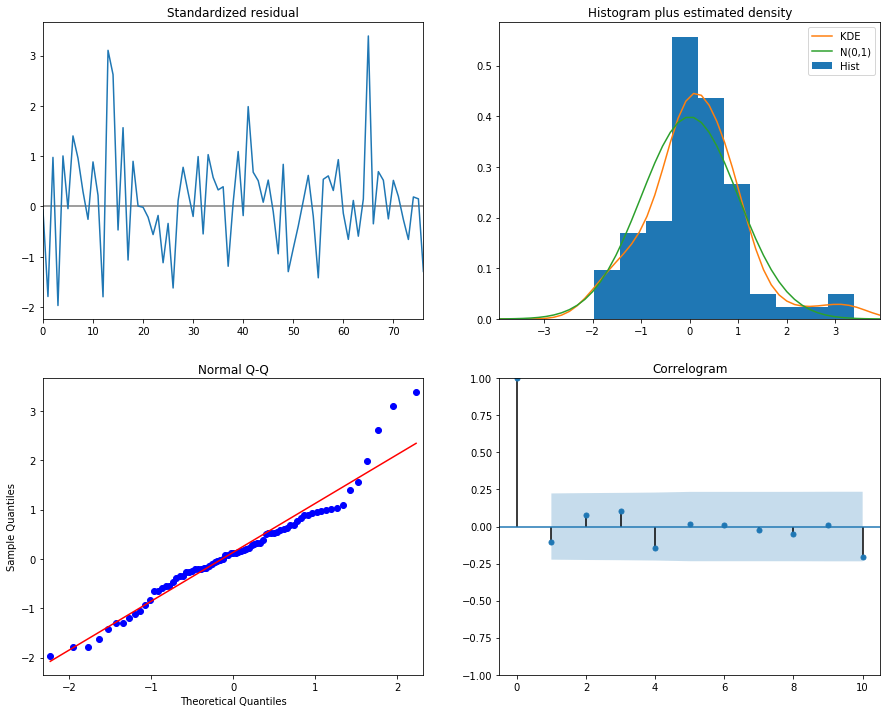

In [127]:
#Step 5: Check our assumptions are correct with the diagonistic plot
results.plot_diagnostics(figsize=(15, 12))
plt.show()

Our primary concern is to ensure that the residuals of our model are uncorrelated 
and normally distributed with zero-mean. If the seasonal ARIMA model does not satisfy 
these properties, it is a good indication that it can be further improved.

In this case, our model diagnostics suggests that the model residuals are normally 
distributed based on the following:

1.In the top right plot, we see that the red KDE line follows closely with the 
N(0,1) line (where N(0,1)) is the standard notation for a normal distribution 
with mean 0 and standard deviation of 1). This is a good indication that the 
residuals are normally distributed.  
2.The qq-plot on the bottom left shows that the ordered distribution of residuals
 (blue dots) follows the linear trend of the samples taken from a standard 
 normal distribution with N(0, 1). Again, this is a strong indication that the 
 residuals are normally distributed.  
3.The residuals over time (top left plot) don't display any obvious seasonality 
and appear to be white noise. This is confirmed by the autocorrelation 
(i.e. correlogram) plot on the bottom right, which shows that the time series 
residuals have low correlation with lagged versions of itself.
Those observations lead us to conclude that our model produces a satisfactory 
fit that could help us understand our time series data and forecast future values.


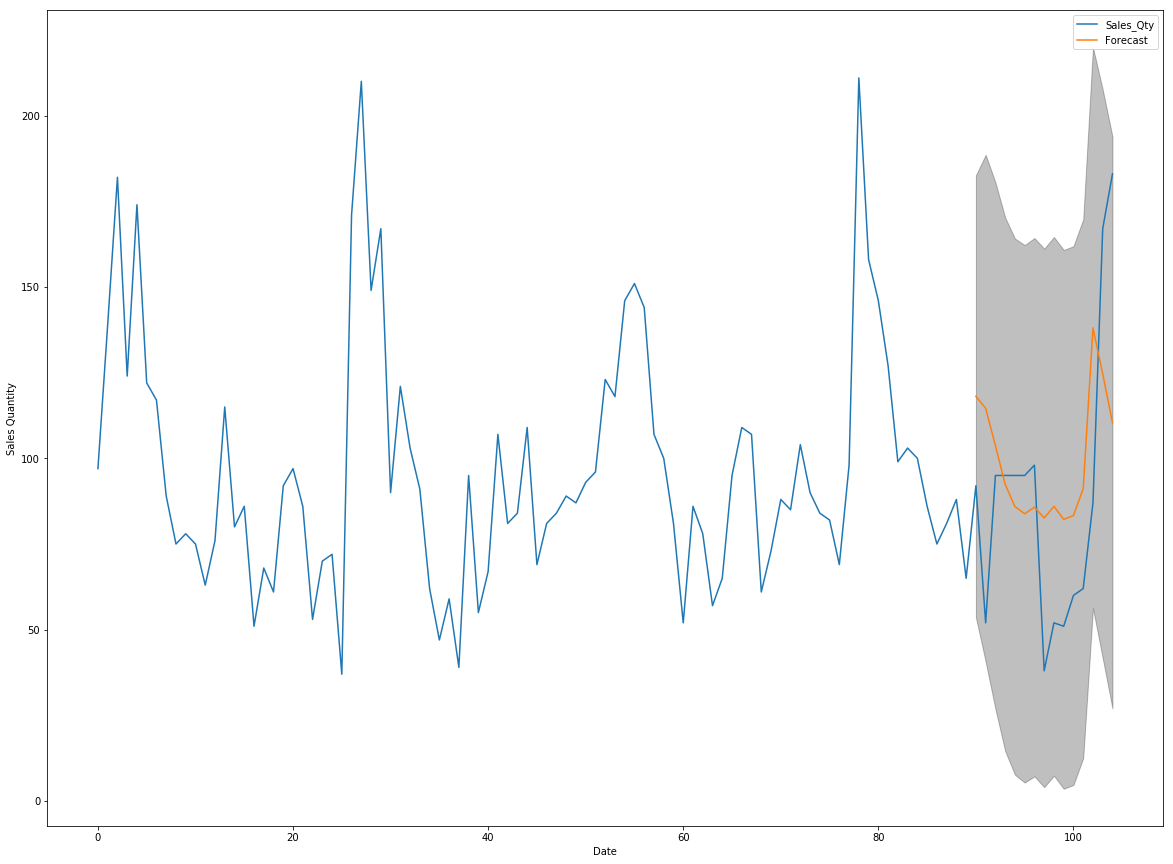

The Mean Squared Error of our forecasts is 1348.09


In [128]:

# Get forecast 15 steps ahead in future
pred_uc = results.get_forecast(steps=15)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()


ax = data.plot(label='observed', figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)

ax.set_xlabel('Date')
ax.set_ylabel('Sales Quantity')

plt.legend()
plt.show()

mse = ((pred_uc.predicted_mean - test.Sales_Qty) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

